In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style for better readability
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

# To display all columns in pandas dataframes
pd.set_option('display.max_columns', None)

In [8]:
# Load the main dataset
df = pd.read_csv('diabetic_data.csv')

# Load the mapping file for IDs
ids_mapping = pd.read_csv('IDS_mapping.csv')

In [9]:
print("Dataset Shape:")
print(df.shape)

print("\nDataset Info:")
df.info()

print("\nFirst 5 Rows:")
display(df.head())

print("\nPresence of '?' for missing values:")
print((df == '?').sum().sort_values(ascending=False).head())

Dataset Shape:
(101766, 50)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures  

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,NaN,NaN,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,NaN,NaN,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO



Presence of '?' for missing values:
weight               98569
medical_specialty    49949
payer_code           40256
race                  2273
diag_3                1423
dtype: int64


Target Variable Distribution:
readmitted_early
0    90409
1    11357
Name: count, dtype: int64

Target Variable Proportions:
readmitted_early
0    0.888401
1    0.111599
Name: proportion, dtype: float64


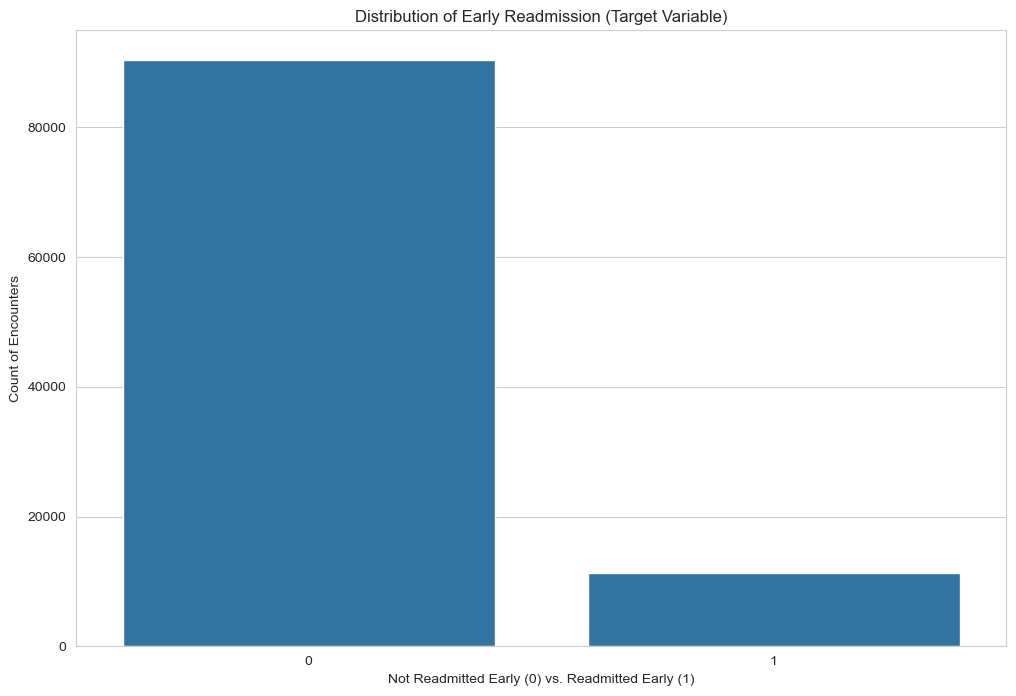

In [10]:
# Create the binary target variable 'readmitted_early'
# '<30' is our positive class (1), '>30' and 'NO' are the negative class (0)
df['readmitted_early'] = df['readmitted'].apply(lambda x: 1 if x == '<30' else 0)

# Drop the original 'readmitted' column
df.drop('readmitted', axis=1, inplace=True)

# Analyze the class distribution
print("Target Variable Distribution:")
print(df['readmitted_early'].value_counts())
print("\nTarget Variable Proportions:")
print(df['readmitted_early'].value_counts(normalize=True))

# Visualize the class imbalance
sns.countplot(x='readmitted_early', data=df)
plt.title('Distribution of Early Readmission (Target Variable)')
plt.xlabel('Not Readmitted Early (0) vs. Readmitted Early (1)')
plt.ylabel('Count of Encounters')
plt.show()

--- Answering RQ1: What is the most common primary diagnosis by age group? ---


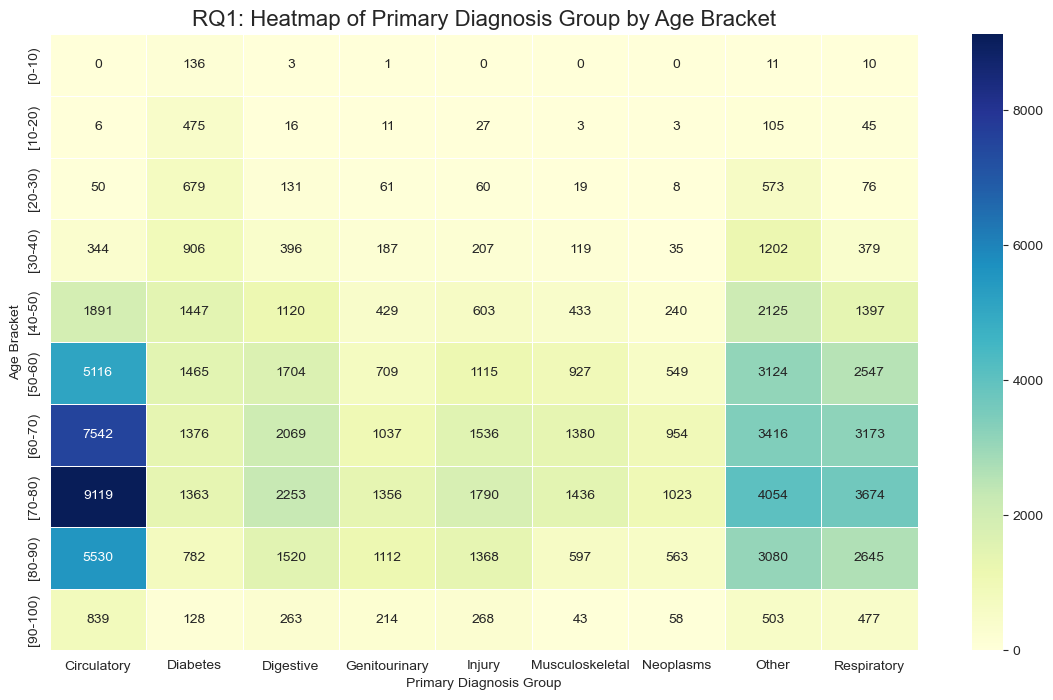


--- Answering RQ2: Effect of Diabetes Markers on Readmission Rates ---


C:\Users\steck\AppData\Local\Temp\ipykernel_13764\3909366845.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='A1Cresult', y='readmitted_early', data=df, ax=axes[0, 0], palette='viridis', order=['None', 'Norm', '>7', '>8'])
C:\Users\steck\AppData\Local\Temp\ipykernel_13764\3909366845.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='change', y='readmitted_early', data=df, ax=axes[0, 1], palette='viridis')
C:\Users\steck\AppData\Local\Temp\ipykernel_13764\3909366845.py:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='diabetesM

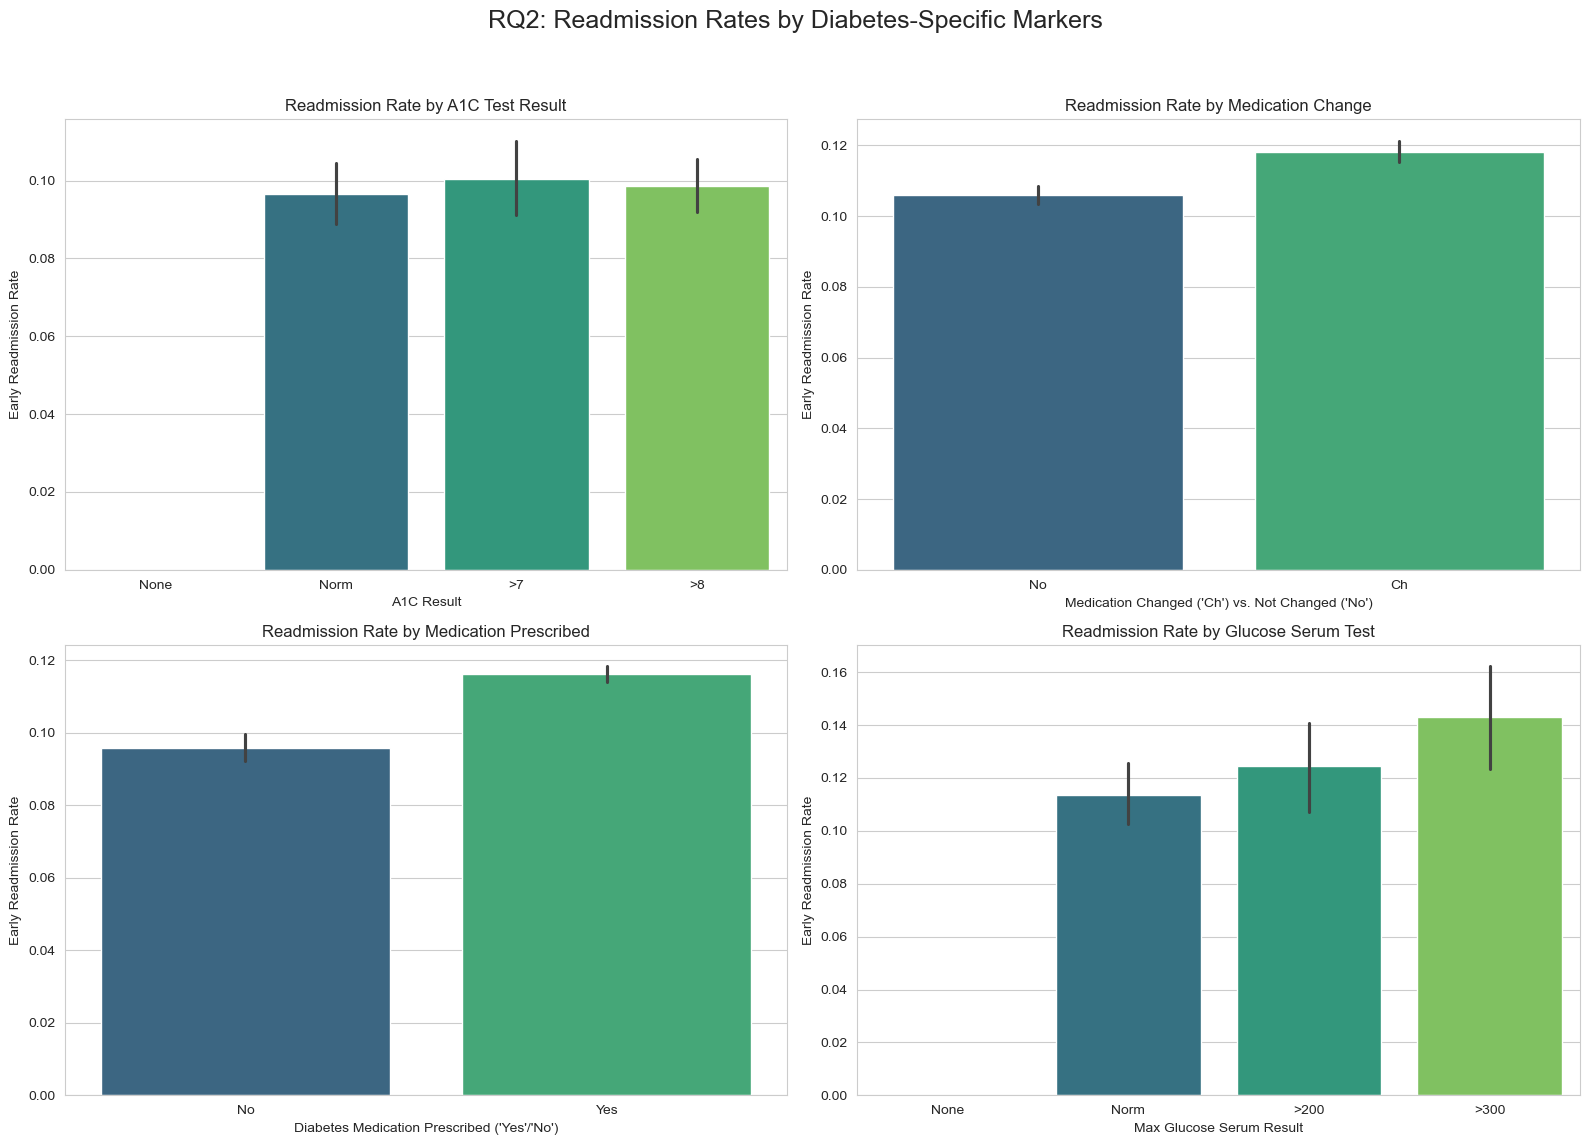

In [11]:
# First, replace '?' with NaN to handle them correctly in groupings
df.replace('?', np.nan, inplace=True)

# --- Answering RQ1: What is the most common primary diagnosis by age group? ---

# To make diagnoses interpretable, we group them by ICD-9 codes.
def map_diag_codes(series):
    # This function takes a pandas Series of diagnosis codes (e.g., df['diag_1'])
    # and maps them to broader clinical categories.
    
    mapping = {
        # Each key is the category name, and the value is a list of ICD-9 integer codes.
        # NOTE: The problematic "'250': 'Diabetes'" entry has been removed.
        'Circulatory': list(range(390, 460)) + [785],
        'Respiratory': list(range(460, 520)) + [786],
        'Digestive': list(range(520, 580)) + [787],
        'Injury': list(range(800, 1000)),
        'Musculoskeletal': list(range(710, 740)),
        'Genitourinary': list(range(580, 630)) + [788],
        'Neoplasms': list(range(140, 240)),
    }
    
    # Initialize a new series with 'Other' as the default category.
    cat_series = pd.Series('Other', index=series.index)
    
    # Convert diagnosis codes to numeric for comparison, handling non-numeric values.
    # We take the part before the decimal point. 'coerce' turns errors into NaN.
    series_val = pd.to_numeric(series.str.split('.').str[0], errors='coerce')
    
    # Iterate through the mapping to assign categories based on the integer code.
    for cat, code_list in mapping.items():
        cat_series[series_val.isin(code_list)] = cat
    
    # Handle the 'Diabetes' category separately. This is more robust as it catches
    # all codes starting with '250', like '250.01', '250.83', etc.
    cat_series[series.str.startswith('250', na=False)] = 'Diabetes'
    
    return cat_series

# Apply the function to create the new grouped diagnosis feature.
df['diag_1_group'] = map_diag_codes(df['diag_1'])

# Create a pivot table and visualize with a heatmap
print("--- Answering RQ1: What is the most common primary diagnosis by age group? ---")
age_diag_pivot = df.groupby(['age', 'diag_1_group']).size().unstack(fill_value=0)
plt.figure(figsize=(14, 8))
sns.heatmap(age_diag_pivot, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5)
plt.title('RQ1: Heatmap of Primary Diagnosis Group by Age Bracket', fontsize=16)
plt.xlabel('Primary Diagnosis Group')
plt.ylabel('Age Bracket')
plt.show()


# --- Answering RQ2: Explore the effect of a diabetes diagnosis on readmission rates ---
print("\n--- Answering RQ2: Effect of Diabetes Markers on Readmission Rates ---")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('RQ2: Readmission Rates by Diabetes-Specific Markers', fontsize=18)

# A1C Test Result
sns.barplot(x='A1Cresult', y='readmitted_early', data=df, ax=axes[0, 0], palette='viridis', order=['None', 'Norm', '>7', '>8'])
axes[0, 0].set_title('Readmission Rate by A1C Test Result')
axes[0, 0].set_ylabel('Early Readmission Rate')
axes[0, 0].set_xlabel('A1C Result')

# Change in Medication
sns.barplot(x='change', y='readmitted_early', data=df, ax=axes[0, 1], palette='viridis')
axes[0, 1].set_title('Readmission Rate by Medication Change')
axes[0, 1].set_ylabel('Early Readmission Rate')
axes[0, 1].set_xlabel("Medication Changed ('Ch') vs. Not Changed ('No')")


# Diabetes Medication Prescribed
sns.barplot(x='diabetesMed', y='readmitted_early', data=df, ax=axes[1, 0], palette='viridis')
axes[1, 0].set_title('Readmission Rate by Medication Prescribed')
axes[1, 0].set_ylabel('Early Readmission Rate')
axes[1, 0].set_xlabel("Diabetes Medication Prescribed ('Yes'/'No')")


# Glucose Serum Test
sns.barplot(x='max_glu_serum', y='readmitted_early', data=df, ax=axes[1, 1], palette='viridis', order=['None', 'Norm', '>200', '>300'])
axes[1, 1].set_title('Readmission Rate by Glucose Serum Test')
axes[1, 1].set_ylabel('Early Readmission Rate')
axes[1, 1].set_xlabel('Max Glucose Serum Result')


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [12]:
# Calculate percentage of missing values
missing_percent = (df.isnull().sum() / len(df) * 100).sort_values(ascending=False)
print("Percentage of missing values per column:")
print(missing_percent.head(10))

# Drop columns with >40% missing values
cols_to_drop = ['weight', 'medical_specialty', 'payer_code']
df.drop(columns=cols_to_drop, inplace=True)
print(f"\nDropped columns with high missingness: {cols_to_drop}")

# Drop identifier columns not useful for a generalized model
df.drop(columns=['encounter_id', 'patient_nbr'], inplace=True)
print("Dropped identifier columns: 'encounter_id', 'patient_nbr'")

# The number of missing values in 'race', 'diag_1', 'diag_2', 'diag_3' is relatively small.
# We will drop the rows with missing 'race', 'diag_1', as they are important features.
df.dropna(subset=['race', 'diag_1'], inplace=True)
print(f"Dropped rows with missing 'race' or 'diag_1'. New shape: {df.shape}")

# There is an 'Unknown/Invalid' value in 'gender' which is effectively a missing/unusable value.
# We will remove these rows as there are only 3 of them.
df = df[df['gender'] != 'Unknown/Invalid']
print(f"Removed 'Unknown/Invalid' gender. New shape: {df.shape}")

Percentage of missing values per column:
weight               96.858479
max_glu_serum        94.746772
A1Cresult            83.277322
medical_specialty    49.082208
payer_code           39.557416
race                  2.233555
diag_3                1.398306
diag_2                0.351787
diag_1                0.020636
patient_nbr           0.000000
dtype: float64

Dropped columns with high missingness: ['weight', 'medical_specialty', 'payer_code']
Dropped identifier columns: 'encounter_id', 'patient_nbr'
Dropped rows with missing 'race' or 'diag_1'. New shape: (99474, 46)
Removed 'Unknown/Invalid' gender. New shape: (99473, 46)


In [13]:
# --- Feature Engineering ---

# 1. Group all diagnosis codes
df['diag_2_group'] = map_diag_codes(df['diag_2'])
df['diag_3_group'] = map_diag_codes(df['diag_3'])

# 2. Create a feature for total number of prior visits
prior_visit_cols = ['number_outpatient', 'number_inpatient', 'number_emergency']
df['num_prior_visits'] = df[prior_visit_cols].sum(axis=1)

# --- Feature Transformation ---

# 1. Ordinal Encoding for 'age'
age_map = {'[0-10)': 5, '[10-20)': 15, '[20-30)': 25, '[30-40)': 35, '[40-50)': 45, 
           '[50-60)': 55, '[60-70)': 65, '[70-80)': 75, '[80-90)': 85, '[90-100)': 95}
df['age_encoded'] = df['age'].map(age_map)

# 2. One-Hot Encode nominal categorical variables
# Identify categorical and numerical columns first
categorical_cols = df.select_dtypes(include=['object']).columns
numerical_cols = df.select_dtypes(include=np.number).columns.drop('readmitted_early')

# For the 24 medication columns, 'No' is the baseline. We are interested in 'Up', 'Down', 'Steady'.
med_cols = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone']
for col in med_cols:
    df[col] = df[col].replace({'No': 0, 'Steady': 1, 'Up': 1, 'Down': 1})
    
df['change'] = df['change'].replace({'No': 0, 'Ch': 1})
df['diabetesMed'] = df['diabetesMed'].replace({'No': 0, 'Yes': 1})


# One-hot encode remaining nominal features
nominal_cols = [
    'race', 'gender', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
    'max_glu_serum', 'A1Cresult', 'diag_1_group', 'diag_2_group', 'diag_3_group'
]
# To avoid issues with unseen categories in test set, we will use pandas get_dummies
df_processed = pd.get_dummies(df, columns=nominal_cols, drop_first=True)

# Drop original columns that have been engineered or encoded
cols_to_drop_final = [
    'age', 'diag_1', 'diag_2', 'diag_3', 'number_outpatient', 
    'number_inpatient', 'number_emergency'
] + list(set(nominal_cols) - set(df.columns)) # In case some were already dropped
df_processed.drop(columns=cols_to_drop_final, inplace=True, errors='ignore')

print("Data after all transformations:")
df_processed.info()

C:\Users\steck\AppData\Local\Temp\ipykernel_13764\361553987.py:26: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace({'No': 0, 'Steady': 1, 'Up': 1, 'Down': 1})
C:\Users\steck\AppData\Local\Temp\ipykernel_13764\361553987.py:28: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['change'] = df['change'].replace({'No': 0, 'Ch': 1})
C:\Users\steck\AppData\Local\Temp\ipykernel_13764\361553987.py:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the

Data after all transformations:
<class 'pandas.core.frame.DataFrame'>
Index: 99473 entries, 0 to 101765
Columns: 114 entries, time_in_hospital to diag_3_group_Respiratory
dtypes: bool(81), int64(33)
memory usage: 33.5 MB


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Define features (X) and target (y)
X = df_processed.drop('readmitted_early', axis=1)
y = df_processed['readmitted_early']

# Split the data into training (80%) and testing (20%) sets
# Use stratify=y to maintain the same class proportion in train and test sets, crucial for imbalanced data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Identify numerical columns to scale (all columns are now numeric, but we scale non-binary ones)
# We can simply scale all of them; scaling binary 0/1 columns has no effect.
scaler = StandardScaler()

# Fit the scaler ONLY on the training data to prevent data leakage from the test set
X_train_scaled = scaler.fit_transform(X_train)
# Apply the SAME transformation to the test data
X_test_scaled = scaler.transform(X_test)

# For convenience, convert back to DataFrames
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

print("Training set shape:", X_train_scaled.shape)
print("Test set shape:", X_test_scaled.shape)
print("\nProportion of positive class in y_train:", y_train.mean())
print("Proportion of positive class in y_test:", y_test.mean())

Training set shape: (79578, 113)
Test set shape: (19895, 113)

Proportion of positive class in y_train: 0.1122295106687778
Proportion of positive class in y_test: 0.1122392560944961
